In [1]:
import tables_io
import qp
import numpy as np

from rail.evaluation.dist_to_dist_evaluator import DistToDistEvaluator
from rail.evaluation.dist_to_point_evaluator import DistToPointEvaluator
from rail.evaluation.point_to_point_evaluator import PointToPointEvaluator
from rail.evaluation.single_evaluator import SingleEvaluator
from rail.core.stage import RailStage
from rail.core.data import QPHandle, TableHandle, QPOrTableHandle

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Load example Data

In [2]:
import os
from rail.core.utils import find_rail_file
possible_local_file = './examples_data/evaluation_data/data/output_fzboost.hdf5'
if os.path.exists(possible_local_file):
    pdfs_file = os.path.abspath(possible_local_file)
else:
    pdfs_file = 'examples_data/evaluation_data/data/output_fzboost.hdf5'
    try:
        os.makedirs(os.path.dirname(pdfs_file))
    except FileExistsError:
        pass
    curl_com = f"curl -o {pdfs_file} https://portal.nersc.gov/cfs/lsst/PZ/output_fzboost.hdf5"
    os.system(curl_com)

ztrue_file = find_rail_file('examples_data/testdata/test_dc2_validation_9816.hdf5')

In [3]:
ensemble = DS.read_file(key='pdfs_data', handle_class=QPHandle, path=pdfs_file)
ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)
#truth = DS.add_data('truth', ztrue_data()['photometry'], TableHandle, path=ztrue_file)
#truth_points = DS.add_data('truth_points', ztrue_data()['photometry']['redshift'], TableHandle, path=ztrue_file)

# Dist to Dist Evaluation

The DistToDistEvaluator is for evaluating metrics that compare distributions to distributions.

To test it we are going to compare a generated p(z) distribution to itself.

Note that there are two modes in which this can be run.   The default mode is to allow evaluation of the metric in parallel across many nodes.   This is much faster, can avoid potential issues with overflowing the memory for huge input data sets, however, when computing quantiles or medians the computation will not be exact (however, with the default parameters it will be very close in almost all cases).  However, if the force_exact configuration variable is set, it will only run on a single node, allowing for an exact calculation, but with the drawback of being slower and more memory intensive.

Here we implement both types, and compare the results.

In [4]:
stage_dict = dict(
    metrics=['cvm', 'ks', 'rmse', 'kld', 'ad'],
    _random_state=None,
)

dtd_stage = DistToDistEvaluator.make_stage(name='dist_to_dist', **stage_dict)
dtd_stage_single = DistToDistEvaluator.make_stage(name='dist_to_dist', force_exact=True, **stage_dict)

In [5]:
# Parallelized implementation
dtd_results = dtd_stage.evaluate(ensemble, ensemble)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Processing 0 running evaluator on chunk 10000 - 20000.
Processing 0 running evaluator on chunk 20000 - 20449.
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


In [6]:
# Non-parallelized, exact implementation
dtd_results_single = dtd_stage_single.evaluate(ensemble, ensemble)

Requested metrics: ['cvm', 'ks', 'rmse', 'kld', 'ad']
Inserting handle into data store.  output_dist_to_dist: inprogress_output_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  summary_dist_to_dist: inprogress_summary_dist_to_dist.hdf5, dist_to_dist
Inserting handle into data store.  single_distribution_summary_dist_to_dist: inprogress_single_distribution_summary_dist_to_dist.hdf5, dist_to_dist


NOTE/WARNING: Expected output file single_distribution_summary_dist_to_dist.hdf5 was not generated.


Here we compare the output data tables.  

In [7]:
results_df = tables_io.convertObj(dtd_results['output'](), tables_io.types.PD_DATAFRAME)
results_df_single = tables_io.convertObj(dtd_results_single['output'](), tables_io.types.PD_DATAFRAME)
results_df

,ad,cvm,kld,ks,rmse
0,1.560647,0.121623,0.0,0.131325,0.0
1,0.818393,0.104253,0.0,0.126633,0.0
2,1.506214,0.073123,0.0,0.060202,0.0
3,0.436833,0.035073,0.0,0.103064,0.0
4,0.294427,0.238308,0.0,0.070398,0.0
...,...,...,...,...,...
20444,1.798028,0.471777,0.0,0.091265,0.0
20445,0.487682,0.183045,0.0,0.094580,0.0
20446,1.049231,0.560374,0.0,0.093545,0.0
20447,0.708184,0.131500,0.0,0.094907,0.0


In [8]:
results_df_single

,cvm,ks,rmse,kld,ad
0,0.121623,0.131325,0.0,0.0,1.560647
1,0.104253,0.126633,0.0,0.0,0.818393
2,0.073123,0.060202,0.0,0.0,1.506214
3,0.035073,0.103064,0.0,0.0,0.436833
4,0.238308,0.070398,0.0,0.0,0.294427
...,...,...,...,...,...
20444,0.471777,0.091265,0.0,0.0,1.798028
20445,0.183045,0.094580,0.0,0.0,0.487682
20446,0.560374,0.093545,0.0,0.0,1.049231
20447,0.131500,0.094907,0.0,0.0,0.708184


# Dist to Point Evaluation

The DistToPointEvaluator is for evaluating metrics that compare distributions (for the p(z)) estimate to point values (for the reference or truth).

To test it we are going to compare a generated p(z) distribution to true redshifts.

Note that as for the DistToDistEvaluator this can be run in parallel or forced to run on a single node for exact results.

In [9]:
stage_dict = dict(
    metrics=['cdeloss', 'pit', 'brier'],
    _random_state=None,
    metric_config={
        'brier': {'limits':(0,3.1)},
        'pit':{'tdigest_compression': 1000},
    }
)
dtp_stage = DistToPointEvaluator.make_stage(name='dist_to_point', **stage_dict)
dtp_stage_single = DistToPointEvaluator.make_stage(name='dist_to_point', force_exact=True, **stage_dict)

In [10]:
dtp_results = dtp_stage.evaluate(ensemble, ztrue_data)
results_df = tables_io.convertObj(dtp_results['summary'](), tables_io.types.PD_DATAFRAME)

dtp_pit = dtp_stage.get_handle('single_distribution_summary').read()['pit']
results_df

Requested metrics: ['cdeloss', 'pit', 'brier']
Processing 0 running evaluator on chunk 0 - 10000.


Inserting handle into data store.  output_dist_to_point: inprogress_output_dist_to_point.hdf5, dist_to_point
Processing 0 running evaluator on chunk 10000 - 20000.


Processing 0 running evaluator on chunk 20000 - 20449.
Inserting handle into data store.  summary_dist_to_point: inprogress_summary_dist_to_point.hdf5, dist_to_point
Inserting handle into data store.  single_distribution_summary_dist_to_point: inprogress_single_distribution_summary_dist_to_point.hdf5, dist_to_point
Warning.  Failed to convert column No conversion path for dtype: dtype('<U16')


,cdeloss,brier
0,-6.751813,732.133867


In [11]:
dtp_results_single = dtp_stage_single.evaluate(ensemble, ztrue_data)
results_df_single = tables_io.convertObj(dtp_results_single['summary'](), tables_io.types.PD_DATAFRAME)

dtp_pit_single = dtp_stage_single.get_handle('single_distribution_summary').read()['pit']
results_df_single

Requested metrics: ['cdeloss', 'pit', 'brier']


Inserting handle into data store.  output_dist_to_point: inprogress_output_dist_to_point.hdf5, dist_to_point
Inserting handle into data store.  summary_dist_to_point: inprogress_summary_dist_to_point.hdf5, dist_to_point
Inserting handle into data store.  single_distribution_summary_dist_to_point: inprogress_single_distribution_summary_dist_to_point.hdf5, dist_to_point
Warning.  Failed to convert column No conversion path for dtype: dtype('<U16')


,cdeloss,brier
0,-6.751813,732.133867


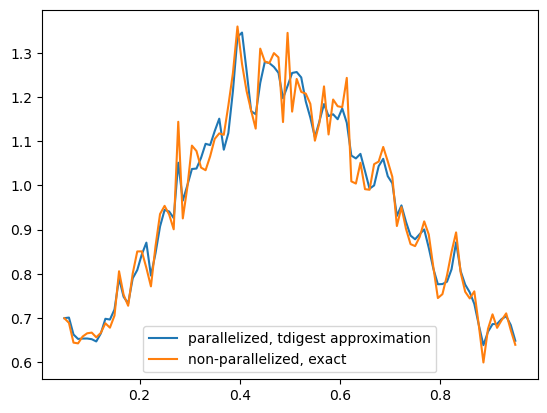

In [12]:
import matplotlib.pyplot as plt

xgrid = np.linspace(0.05,0.95,100)
a_pdf = dtp_pit.pdf(xgrid)
b_pdf = dtp_pit_single.pdf(xgrid)

plt.figure()
plt.plot(xgrid, np.squeeze(a_pdf), label='parallelized, tdigest approximation')
plt.plot(xgrid, np.squeeze(b_pdf), label='non-parallelized, exact')
plt.legend()
plt.show()

# Point to Point Evaluation

The {pomtToPointEvaluator is for evaluating metrics that compare point estimates (for the p(z)) to point values (for the reference or truth).

To test it we are going to compare the mode of p(z) distribution to true redshifts.

Note that as for the DistToDistEvaluator this can be run in parallel or forced to run on a single node for exact results.

In [13]:
stage_dict = dict(
    metrics=['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad'],
    _random_state=None,
    hdf5_groupname='photometry',
    point_estimate_key='zmode',
    chunk_size=10000,
    metric_config={
        'point_stats_iqr':{'tdigest_compression': 100},
    }
)
ptp_stage = PointToPointEvaluator.make_stage(name='point_to_point', **stage_dict)
ptp_stage_single = PointToPointEvaluator.make_stage(name='point_to_point', force_exact=True, **stage_dict)

In [14]:
ptp_results = ptp_stage.evaluate(ensemble, ztrue_data)
results_summary = tables_io.convertObj(ptp_stage.get_handle('summary')(), tables_io.types.PD_DATAFRAME)
results_summary

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Processing 0 running evaluator on chunk 0 - 10000.
Inserting handle into data store.  output_point_to_point: inprogress_output_point_to_point.hdf5, point_to_point
Processing 0 running evaluator on chunk 10000 - 20000.
Processing 0 running evaluator on chunk 20000 - 20449.
Inserting handle into data store.  summary_point_to_point: inprogress_summary_point_to_point.hdf5, point_to_point
Inserting handle into data store.  single_distribution_summary_point_to_point: inprogress_single_distribution_summary_point_to_point.hdf5, point_to_point


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point.hdf5 was not generated.


,point_stats_iqr,point_bias,point_outlier_rate,point_stats_sigma_mad
0,0.021287,0.000208,0.107829,0.020918


In [15]:
ptp_results_single = ptp_stage_single.evaluate(ensemble, ztrue_data)
results_summary_single = tables_io.convertObj(ptp_stage_single.get_handle('summary')(), tables_io.types.PD_DATAFRAME)
results_summary_single

Requested metrics: ['point_stats_ez', 'point_stats_iqr', 'point_bias', 'point_outlier_rate', 'point_stats_sigma_mad']
Inserting handle into data store.  output_point_to_point: inprogress_output_point_to_point.hdf5, point_to_point
Inserting handle into data store.  summary_point_to_point: inprogress_summary_point_to_point.hdf5, point_to_point
Inserting handle into data store.  single_distribution_summary_point_to_point: inprogress_single_distribution_summary_point_to_point.hdf5, point_to_point


NOTE/WARNING: Expected output file single_distribution_summary_point_to_point.hdf5 was not generated.


,point_stats_iqr,point_bias,point_outlier_rate,point_stats_sigma_mad
0,0.020847,0.000266,0.107096,0.020865


Above we see the effect of the approximation used when running in parallel.  Here we are to do the computation in qp to confirm the exact value is correct.

In [16]:
truth = ztrue_data()['photometry']['redshift']
estimates = np.squeeze(ensemble().ancil['zmode'])
#truth_points = DS.add_data('truth_points', ztrue_data()['photometry']['redshift'], TableHandle, path=ztrue_file)

In [17]:
check_iqr = qp.metrics.point_estimate_metric_classes.PointSigmaIQR().evaluate(estimates, truth)

In [18]:
check_iqr

0.02084700447796729

### Setting up a RailPipeline with an evaluation stage

In [19]:
inputs = {
    'pdfs_data':'examples_data/evaluation_data/data/output_fzboost.hdf5',
    'ztrue_data':'examples_data/test_dc2_validation_9816.hdf5',
}
outputs = {
    'output':'output.hdf5',
    'summary':'summary.hdf5',
}

In [20]:
from rail.core import RailPipeline

In [21]:
pipe = RailPipeline()

In [22]:
pipe.add_stage(ptp_stage)

{'output_point_to_point': './output_point_to_point.hdf5',
 'summary_point_to_point': './summary_point_to_point.hdf5',
 'single_distribution_summary_point_to_point': './single_distribution_summary_point_to_point.hdf5'}

In [23]:
pipe.initialize(overall_inputs=inputs, run_config={'output_dir':'.', 'log_dir':'.', 'resume':False}, stages_config=None)

(({'point_to_point': <Job point_to_point>},
  [<rail.evaluation.point_to_point_evaluator.PointToPointEvaluator at 0x17fd22290>]),
 {'output_dir': '.', 'log_dir': '.', 'resume': False})

In [24]:
pipe.save('eval_pipe.yaml')

## Single Evaluator

The SingletEvaluator is will computate all of the metrics that it can for the inputs that it is given.

It will check to see if the estimate and reference inputs are point estimates or distributions, (or potentially both, e.g., if the use asks to use the mode or median of the distribution as a point estimate.)

To test it we are going to compare a generated p(z) distribution to true redshifts.

Note that as for the DistToDistEvaluator this can be run in parallel or forced to run on a single node for exact results.

In [25]:
stage_dict = dict(
    metrics=['cvm', 'ks', 'omega', 'kld', 'cdeloss', 'point_stats_ez', 'point_stats_iqr'],
    _random_state=None,
    hdf5_groupname='photometry',
    point_estimates=['zmode'],
    truth_point_estimates=['redshift'],
    chunk_size=1000,
)
ensemble_d = DS.add_data('pdfs_data_2', None, QPOrTableHandle, path=pdfs_file)
ztrue_data_d = DS.add_data('ztrue_data_2', None, QPOrTableHandle, path=ztrue_file)

single_stage = SingleEvaluator.make_stage(name='single', **stage_dict)
single_stage_single = SingleEvaluator.make_stage(name='single', force_exact=True, **stage_dict)

In [26]:
single_results = single_stage.evaluate(ensemble_d, ztrue_data_d)

This is not a qp file because 'meta'
This is not a qp file because 'meta'
Unsupported metric requested: 'omega'.  Available metrics are: ['ad', 'brier', 'cdeloss', 'cvm', 'kld', 'ks', 'moment', 'outlier', 'pit', 'point_bias', 'point_outlier_rate', 'point_stats_ez', 'point_stats_iqr', 'point_stats_sigma_mad', 'rbpe', 'rmse']
Requested metrics: ['cvm', 'ks', 'kld', 'cdeloss', 'point_stats_ez', 'point_stats_iqr']
This is not a qp file because 'meta'
This is not a qp file because 'meta'
This is not a qp file because 'meta'
Processing 0 running evaluator on chunk 0 - 1000.
skipping cvm PdfOrValue.both MetricInputType.dist_to_dist
skipping ks PdfOrValue.both MetricInputType.dist_to_dist
skipping kld PdfOrValue.both MetricInputType.dist_to_dist
Inserting handle into data store.  output_single: inprogress_output_single.hdf5, single
Processing 0 running evaluator on chunk 1000 - 2000.
skipping cvm PdfOrValue.both MetricInputType.dist_to_dist
skipping ks PdfOrValue.both MetricInputType.dist_to_d

NOTE/WARNING: Expected output file single_distribution_summary_single.hdf5 was not generated.


In [27]:
single_results_single = single_stage_single.evaluate(ensemble_d, ztrue_data_d)

This is not a qp file because 'meta'
Unsupported metric requested: 'omega'.  Available metrics are: ['ad', 'brier', 'cdeloss', 'cvm', 'kld', 'ks', 'moment', 'outlier', 'pit', 'point_bias', 'point_outlier_rate', 'point_stats_ez', 'point_stats_iqr', 'point_stats_sigma_mad', 'rbpe', 'rmse']
Requested metrics: ['cvm', 'ks', 'kld', 'cdeloss', 'point_stats_ez', 'point_stats_iqr']
Inserting handle into data store.  output_single: inprogress_output_single.hdf5, single
Inserting handle into data store.  summary_single: inprogress_summary_single.hdf5, single
Inserting handle into data store.  single_distribution_summary_single: inprogress_single_distribution_summary_single.hdf5, single


NOTE/WARNING: Expected output file single_distribution_summary_single.hdf5 was not generated.


In [28]:
single_stage.get_handle('output')()

{'point_stats_ez_zmode_redshift': array([[-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        [-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        [-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        ...,
        [ 2.90989226,  2.91436839,  2.83070909, ..., -0.00522614,
          0.00476253,  0.0103131 ],
        [ 2.67529872,  2.67950628,  2.60086655, ..., -0.06491258,
         -0.05552322, -0.05030568],
        [ 2.90989226,  2.91436839,  2.83070909, ..., -0.00522614,
          0.00476253,  0.0103131 ]])}

In [29]:
single_stage.get_handle('summary')()

{'cdeloss_redshift': array([-6.75181317]),
 'point_stats_iqr_zmode_redshift': array([0.33537443])}

In [30]:
single_stage_single.get_handle('output')()

{'point_stats_ez_zmode_redshift': array([[-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        [-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        [-0.02252694, -0.0214079 , -0.04232273, ..., -0.75130654,
         -0.74880937, -0.74742172],
        ...,
        [ 2.90989226,  2.91436839,  2.83070909, ..., -0.00522614,
          0.00476253,  0.0103131 ],
        [ 2.67529872,  2.67950628,  2.60086655, ..., -0.06491258,
         -0.05552322, -0.05030568],
        [ 2.90989226,  2.91436839,  2.83070909, ..., -0.00522614,
          0.00476253,  0.0103131 ]])}

In [31]:
single_stage_single.get_handle('summary')()

{'cdeloss_redshift': array([-6.75181317]),
 'point_stats_iqr_zmode_redshift': array([0.33537443])}

# CDF-based Metrics

### PIT

The Probability Integral Transform (PIT), is the Cumulative Distribution Function (CDF) of the photo-z PDF 

$$ \mathrm{CDF}(f, q)\ =\ \int_{-\infty}^{q}\ f(z)\ dz $$

evaluated at the galaxy's true redshift for every galaxy $i$ in the catalog.

$$ \mathrm{PIT}(p_{i}(z);\ z_{i})\ =\ \int_{-\infty}^{z^{true}_{i}}\ p_{i}(z)\ dz $$ 


In [32]:
fzdata = DS.read_file('pdfs_data', QPHandle, pdfs_file)
ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)
ztrue = ztrue_data()['photometry']['redshift']
zgrid = fzdata().metadata()['xvals'].ravel()
photoz_mode = fzdata().mode(grid=zgrid)

In [33]:
from qp.metrics.pit import PIT
pitobj = PIT(fzdata(), ztrue)
quant_ens = pitobj.pit
metamets = pitobj.calculate_pit_meta_metrics()

/Users/echarles/software/DESC/qp/src/qp/metrics/array_metrics.py:27: UserWarning: p-value floored: true value smaller than 0.001
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


The evaluate method PIT class returns two objects, a quantile distribution based on the full set of PIT values (a frozen distribution object), and a dictionary of meta metrics associated to PIT (to be detailed below). 

In [34]:
quant_ens

In [35]:
metamets

{'ad': Anderson_ksampResult(statistic=84.95623553609381, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001),
 'cvm': CramerVonMisesResult(statistic=9.62335199605935, pvalue=9.265033185101856e-10),
 'ks': KstestResult(statistic=0.033590049370962216, pvalue=1.7621068075751534e-20, statistic_location=0.9921210288809627, statistic_sign=-1),
 'outlier_rate': 0.058737978774663246}

In [36]:
pit_vals = np.array(pitobj.pit_samps)
pit_vals

array([0.19392947, 0.36675619, 0.52017547, ..., 1.        , 0.93189232,
       0.4674437 ])

In [37]:
pit_out_rate = metamets['outlier_rate']
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}") 
pit_out_rate = pitobj.evaluate_PIT_outlier_rate()
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}") 

PIT outlier rate of this sample: 0.058738
PIT outlier rate of this sample: 0.058738


### PIT-QQ plot

The histogram of PIT values is a useful tool for a qualitative assessment of PDFs quality. It shows whether the PDFs are:
* biased (tilted PIT histogram)
* under-dispersed (excess counts close to the boudaries 0 and 1)
* over-dispersed (lack of counts close the boudaries 0 and 1)
* well-calibrated (flat histogram)

Following the standards in DC1 paper, the PIT histogram is accompanied by the quantile-quantile (QQ), which can be used to compare qualitatively the PIT distribution obtained with the PDFs agaist the ideal case (uniform distribution). The closer the QQ plot is to the diagonal, the better is the PDFs calibration. 

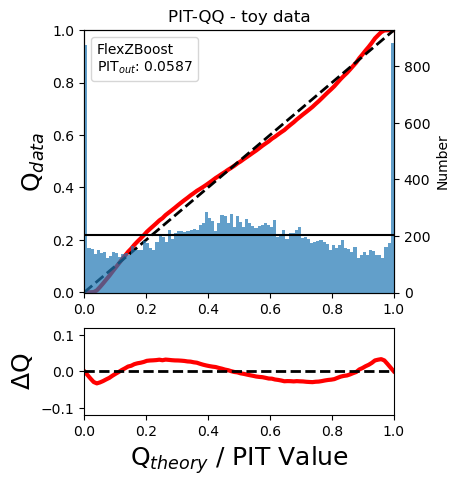

In [38]:
from utils import plot_pit_qq, ks_plot
pdfs = fzdata.data.objdata()['yvals']
plot_pit_qq(pdfs, zgrid, ztrue, title="PIT-QQ - toy data", code="FlexZBoost",
                pit_out_rate=pit_out_rate, savefig=False)

The black horizontal line represents the ideal case where the PIT histogram would behave as a uniform distribution U(0,1).

## Summary statistics of CDF-based metrics

To evaluate globally the quality of PDFs estimates, `rail.evaluation` provides a set of metrics to compare the empirical distributions of PIT values with the reference uniform distribution, U(0,1). 

### Kolmogorov-Smirnov  

Let's start with the traditional Kolmogorov-Smirnov (KS) statistic test, which is the maximum difference between the empirical and the expected cumulative distributions of PIT values:

$$
\mathrm{KS} \equiv \max_{PIT} \Big( \left| \ \mathrm{CDF} \small[ \hat{f}, z \small] - \mathrm{CDF} \small[ \tilde{f}, z \small] \  \right| \Big)
$$

Where $\hat{f}$ is the PIT distribution and $\tilde{f}$ is U(0,1). Therefore, the smaller value of KS the closer the PIT distribution is to be uniform. The `evaluate` method of the PITKS class returns a named tuple with the statistic and p-value. 

In [39]:
ks_stat_and_pval = metamets['ks']
print(f"PIT KS stat and pval: {ks_stat_and_pval}") 
ks_stat_and_pval = pitobj.evaluate_PIT_KS()
print(f"PIT KS stat and pval: {ks_stat_and_pval}") 

PIT KS stat and pval: KstestResult(statistic=0.033590049370962216, pvalue=1.7621068075751534e-20, statistic_location=0.9921210288809627, statistic_sign=-1)
PIT KS stat and pval: KstestResult(statistic=0.033590049370962216, pvalue=1.7621068075751534e-20, statistic_location=0.9921210288809627, statistic_sign=-1)


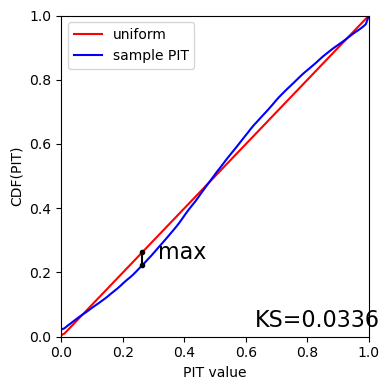

In [40]:
ks_plot(pitobj)

In [41]:
print(f"KS metric of this sample: {ks_stat_and_pval.statistic:.4f}") 

KS metric of this sample: 0.0336


### Cramer-von Mises

Similarly, let's calculate the Cramer-von Mises (CvM) test, a variant of the KS statistic defined as the mean-square difference between the CDFs of an empirical PDF and the true PDFs:

$$ \mathrm{CvM}^2 \equiv \int_{-\infty}^{\infty} \Big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \Big)^{2} \mathrm{dCDF}(\tilde{f}, z) $$ 

on the distribution of PIT values, which should be uniform if the PDFs are perfect.

In [42]:
cvm_stat_and_pval = metamets['cvm']
print(f"PIT CvM stat and pval: {cvm_stat_and_pval}") 
cvm_stat_and_pval = pitobj.evaluate_PIT_CvM()
print(f"PIT CvM stat and pval: {cvm_stat_and_pval}")

PIT CvM stat and pval: CramerVonMisesResult(statistic=9.62335199605935, pvalue=9.265033185101856e-10)
PIT CvM stat and pval: CramerVonMisesResult(statistic=9.62335199605935, pvalue=9.265033185101856e-10)


In [43]:
print(f"CvM metric of this sample: {cvm_stat_and_pval.statistic:.4f}") 

CvM metric of this sample: 9.6234


### Anderson-Darling 

Another variation of the KS statistic is the Anderson-Darling (AD) test, a weighted mean-squared difference featuring enhanced sensitivity to discrepancies in the tails of the distribution. 

$$ \mathrm{AD}^2 \equiv N_{tot} \int_{-\infty}^{\infty} \frac{\big( \mathrm{CDF} \small[ \hat{f}, z \small] \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)^{2}}{\mathrm{CDF} \small[ \tilde{f}, z \small] \big( 1 \ - \ \mathrm{CDF} \small[ \tilde{f}, z \small] \big)}\mathrm{dCDF}(\tilde{f}, z) $$ 



In [44]:
ad_stat_crit_sig = metamets['ad']
print(f"PIT AD stat and pval: {ad_stat_crit_sig}") 
ad_stat_crit_sig = pitobj.evaluate_PIT_anderson_ksamp()
print(f"PIT AD stat and pval: {ad_stat_crit_sig}")

PIT AD stat and pval: Anderson_ksampResult(statistic=84.95623553609381, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)
PIT AD stat and pval: Anderson_ksampResult(statistic=84.95623553609381, critical_values=array([0.325, 1.226, 1.961, 2.718, 3.752, 4.592, 6.546]), pvalue=0.001)


/Users/echarles/software/DESC/qp/src/qp/metrics/array_metrics.py:27: UserWarning: p-value floored: true value smaller than 0.001
  return stats.anderson_ksamp([p_random_variables, q_random_variables], **kwargs)


In [45]:
print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}") 

AD metric of this sample: 84.9562


It is possible to remove catastrophic outliers before calculating the integral for the sake of preserving numerical instability. For instance, Schmidt et al. computed the Anderson-Darling statistic within the interval (0.01, 0.99).

In [46]:
ad_stat_crit_sig_cut = pitobj.evaluate_PIT_anderson_ksamp(pit_min=0.01, pit_max=0.99)
print(f"AD metric of this sample: {ad_stat_crit_sig.statistic:.4f}") 
print(f"AD metric for 0.01 < PIT < 0.99: {ad_stat_crit_sig_cut.statistic:.4f}") 

AD metric of this sample: 84.9562
AD metric for 0.01 < PIT < 0.99: 89.9826


## CDE Loss

In the absence of true photo-z posteriors, the metric used to evaluate individual PDFs is the **Conditional Density Estimate (CDE) Loss**, a metric analogue to the root-mean-squared-error:

$$ L(f, \hat{f}) \equiv  \int \int {\big(f(z | x) - \hat{f}(z | x) \big)}^{2} dzdP(x), $$ 

where $f(z | x)$ is the true photo-z PDF and $\hat{f}(z | x)$ is the estimated PDF in terms of the photometry $x$. Since $f(z | x)$  is unknown, we estimate the **CDE Loss** as described in [Izbicki & Lee, 2017 (arXiv:1704.08095)](https://arxiv.org/abs/1704.08095). :

$$ \mathrm{CDE} = \mathbb{E}\big(  \int{{\hat{f}(z | X)}^2 dz} \big) - 2{\mathbb{E}}_{X, Z}\big(\hat{f}(Z, X) \big) + K_{f},  $$


where the first term is the expectation value of photo-z posterior with respect to the marginal distribution of the covariates X, and the second term is the expectation value  with respect to the joint distribution of observables X and the space Z of all possible redshifts (in practice, the centroids of the PDF bins), and the third term is a constant depending on the true conditional densities $f(z | x)$. 

In [47]:
from rail.evaluation.metrics.cdeloss import *
cdelossobj = CDELoss(fzdata.data, zgrid, ztrue)

In [48]:
cde_stat_and_pval = cdelossobj.evaluate()
cde_stat_and_pval

stat_and_pval(statistic=-6.725602928688286, p_value=nan)

In [49]:
print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}") 

CDE loss of this sample: -6.73
